In [1]:
import lamination_station
import os
import anndata
import scanpy as sc
import seaborn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import networkx as nx
# import cuml
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A100-PCIE-40GB


# Dataset

Should be a pandas table with an x column, y column and a classification

- Removing glia or cell types not expected to define your structures is highly recommended

- Orienting your sections isn't necessary

- BUT-Make sure your sections are not overlapping in your x,y space
  - You can just add a different arbitrary large number to x or y for each separate tissue section

In [2]:
x_col = 'transformed_center_x'
y_col = 'transformed_center_y'
taxon_level = 'consensus_cluster'

In [3]:
# making my dataframe
merged_adata = sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/MERFISH/MERFISH_main_sections_3_scVI.h5ad')
merged_adata.obs['segment'] = merged_adata.obs['segment'].cat.reorder_categories(['Cervical','Thoracic','Lumbar','Sacral'])

merged_adata.obs['consensus_cluster'] = merged_adata.obs['consensus_cluster_Hierarchical_AIBS_SpC_consensus'].astype('category')

drg_cells = (merged_adata.obs[x_col]>32100) & (merged_adata.obs[x_col]<34000)
merged_adata = merged_adata[(merged_adata.obs['avg_correlation.Hierarchical.Group_AIBS_SpC_consensus']>0.2)&~drg_cells& ((merged_adata.obs['Class']!='Non-Neurons')),:]#|merged_adata.obs['Subclass'].str.contains('Astro|Ependy'))

gc = merged_adata.obs.loc[:,['Group','consensus_cluster']].drop_duplicates()
gc = gc.loc[gc['Group'].str.contains('Astro|Ependy'),:]
merged_adata.obs["consensus_cluster_astrofix"] = merged_adata.obs["consensus_cluster"].replace(dict(zip(gc['consensus_cluster'],gc['Group'])))

df = merged_adata.obs
df.to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/MERFISH/merfish_coords_classes.tsv',sep='\t')

/scratch/fast/1713219/ipykernel_2647096/1022172612.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  merged_adata.obs["consensus_cluster_astrofix"] = merged_adata.obs["consensus_cluster"].replace(dict(zip(gc['consensus_cluster'],gc['Group'])))


In [4]:
# commented to keep categoricals
# df = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/SpinalCord/manuscript/MERFISH/merfish_coords_classes.tsv',sep='\t',index_col=0)

In [5]:
df.loc[:,[x_col,y_col,taxon_level]] #This is what your starting data frame should look like

,transformed_center_x,transformed_center_y,consensus_cluster
1414851562_48,39261.890625,13759.693359,234
1414851562_53,39324.238281,13858.083984,259
1414851562_66,39405.285156,13974.269531,182
1414851562_88,39466.882812,13951.601562,32
1414851562_93,39447.710938,13877.498047,191
...,...,...,...
1414851227_44459,17809.464844,12280.335938,136
1414851227_44490,17861.003906,12153.470703,136
1414851227_44669,15992.552734,10670.911133,188
1414851227_44762,18312.498047,15827.815430,62


In [6]:
df_grads,cell_types,gradients,comp_vectors_pca,comp_vectors,neighbor_counts,neighbor_type_vecs = lamination_station.pp.calculate_comp_grads(
    df,
    x_col,
    y_col,
    celltype_col=taxon_level,
    near_k=30,far_k=60,
    near_quantile=0.9,far_quantile=0.9, # Uncomment this block if you have QC gradients leading to differences in detected cell density
    use_cuda=True,grad_clip=0.9
)

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/lamination_station/src/lamination_station/preprocessing.py:201: RuntimeWarning: divide by zero encountered in divide
  np.minimum(1.0, threshold/norms),


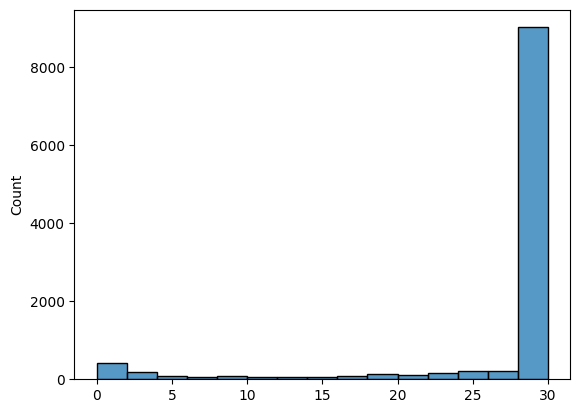

In [7]:
# #Uncomment this block if you have QC gradients leading to differences in detected cell density
seaborn.histplot(neighbor_counts.sum(1))
plt.show()
counts_over_thresh = neighbor_counts.sum(1)>10 #Keep cells with more than 10 neighbors within threshold
df_grads,cell_types,gradients,comp_vectors_pca,comp_vectors,neighbor_counts,neighbor_type_vecs = df_grads.loc[counts_over_thresh,:],cell_types[counts_over_thresh],gradients[counts_over_thresh],comp_vectors_pca[counts_over_thresh],comp_vectors[counts_over_thresh],neighbor_counts.loc[counts_over_thresh],neighbor_type_vecs.loc[counts_over_thresh]

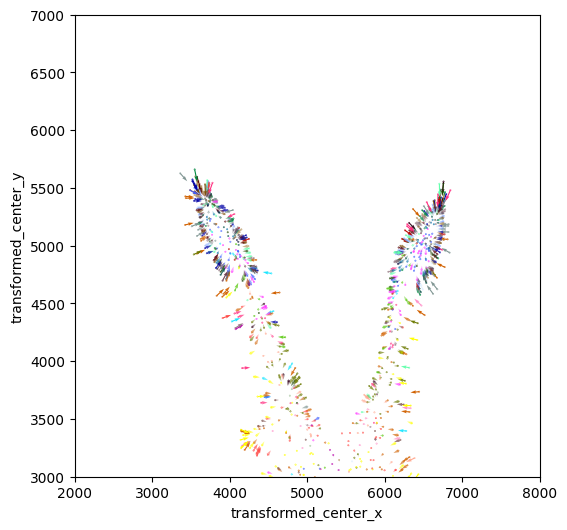

In [8]:
# Just plotting arrows
xlim = (2000,8000) # You'll need to pick your own coords
ylim = (3000,7000)
lamination_station.pl.plot_gradient_arrows(df_grads,gradients,'Group',x_col,y_col,xlim,ylim,scale=0.004)

Epoch:  10%|█         | 100/1000 [01:37<12:06,  1.24it/s]

[Epoch 100] avg ELBO loss: 122138.33


Epoch:  20%|██        | 200/1000 [03:04<13:14,  1.01it/s]

[Epoch 200] avg ELBO loss: 120563.95


Epoch:  30%|███       | 300/1000 [04:25<09:25,  1.24it/s]

[Epoch 300] avg ELBO loss: 119527.46


Epoch:  40%|████      | 400/1000 [05:42<07:15,  1.38it/s]

[Epoch 400] avg ELBO loss: 119486.70


Epoch:  50%|█████     | 500/1000 [07:02<07:42,  1.08it/s]

[Epoch 500] avg ELBO loss: 118402.82


Epoch:  60%|██████    | 600/1000 [08:17<04:40,  1.43it/s]

[Epoch 600] avg ELBO loss: 117626.01


Epoch:  70%|███████   | 700/1000 [09:32<03:52,  1.29it/s]

[Epoch 700] avg ELBO loss: 117527.45


Epoch:  80%|████████  | 800/1000 [10:43<02:14,  1.49it/s]

[Epoch 800] avg ELBO loss: 117304.70


Epoch:  90%|█████████ | 900/1000 [11:52<01:04,  1.54it/s]

[Epoch 900] avg ELBO loss: 117226.57


Epoch: 100%|██████████| 1000/1000 [13:02<00:00,  1.28it/s]


[Epoch 1000] avg ELBO loss: 117248.64


Epoch:  10%|█         | 100/1000 [01:27<13:15,  1.13it/s]

[Epoch 100] avg ELBO loss: 116998.90


Epoch:  20%|██        | 200/1000 [03:01<12:20,  1.08it/s]

[Epoch 200] avg ELBO loss: 117311.65


Epoch:  30%|███       | 300/1000 [04:31<09:43,  1.20it/s]

[Epoch 300] avg ELBO loss: 117029.68


Epoch:  40%|████      | 400/1000 [06:04<08:40,  1.15it/s]

[Epoch 400] avg ELBO loss: 116882.43


Epoch:  50%|█████     | 500/1000 [07:39<07:57,  1.05it/s]

[Epoch 500] avg ELBO loss: 117410.18


Epoch:  60%|██████    | 600/1000 [09:10<05:34,  1.19it/s]

[Epoch 600] avg ELBO loss: 117354.14


Epoch:  70%|███████   | 700/1000 [10:44<04:34,  1.09it/s]

[Epoch 700] avg ELBO loss: 117295.02


Epoch:  80%|████████  | 800/1000 [12:14<02:50,  1.17it/s]

[Epoch 800] avg ELBO loss: 117200.78


Epoch:  90%|█████████ | 900/1000 [13:44<01:23,  1.19it/s]

[Epoch 900] avg ELBO loss: 117292.30


Epoch: 100%|██████████| 1000/1000 [15:17<00:00,  1.09it/s]


[Epoch 1000] avg ELBO loss: 117308.91


Epoch:  10%|█         | 100/1000 [01:28<12:33,  1.19it/s]

[Epoch 100] avg ELBO loss: 117498.54


Epoch:  20%|██        | 200/1000 [03:02<11:51,  1.12it/s]

[Epoch 200] avg ELBO loss: 117285.75


Epoch:  30%|███       | 300/1000 [04:32<10:02,  1.16it/s]

[Epoch 300] avg ELBO loss: 117247.09


Epoch:  40%|████      | 400/1000 [06:04<08:30,  1.18it/s]

[Epoch 400] avg ELBO loss: 117021.75


Epoch:  50%|█████     | 500/1000 [07:35<07:17,  1.14it/s]

[Epoch 500] avg ELBO loss: 116727.71


Epoch:  60%|██████    | 600/1000 [09:04<08:28,  1.27s/it]

[Epoch 600] avg ELBO loss: 117274.73


Epoch:  70%|███████   | 700/1000 [10:35<04:18,  1.16it/s]

[Epoch 700] avg ELBO loss: 116991.38


Epoch:  80%|████████  | 800/1000 [12:04<02:44,  1.21it/s]

[Epoch 800] avg ELBO loss: 117067.14


Epoch:  90%|█████████ | 900/1000 [13:33<01:21,  1.23it/s]

[Epoch 900] avg ELBO loss: 117271.91


Epoch: 100%|██████████| 1000/1000 [15:02<00:00,  1.11it/s]

[Epoch 1000] avg ELBO loss: 117085.06


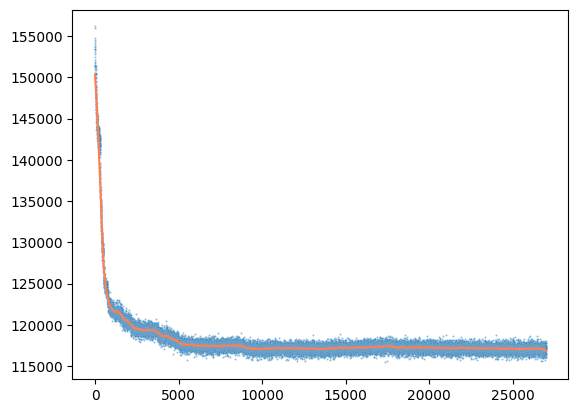

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

out,struct_logits,struct_comp,losses = lamination_station.model.run_model(
    df_grads,
    cell_types,
    neighbor_counts,
    gradients,
    neighbor_type_vecs,
    LATENT_DIM = 2,
    NUM_STRUCTURES = 20, # might need to play with this, pick a number more than your expected structures
    num_epochs=1000, #Could get away with way fewer
    lr_steps = [8e-3,1e-3,1e-4],
    batch_size = 1024,
    STRUCT_SCALE_SCALE = .1, # Penalize broadness structure definitions
    OBS_FAMILY = "poisson",
    STRUCT_LOC_PRIOR_SCALE = 1., #lower penalizes cluster redundancy more
    LOSS_SCALE = 1., #loss scalar multiplier (only use if loss is crazy big/small)
    HIDDEN_DIM = 512, #Encoder/decoder dim
    HIDDEN_DIM_CLASSIFIER = 128, # classifier dim
    device = device
)

lamination_station.pl.plot_loss(losses)

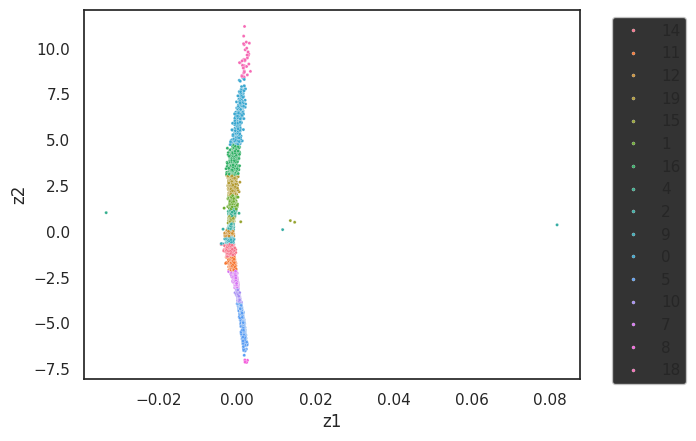

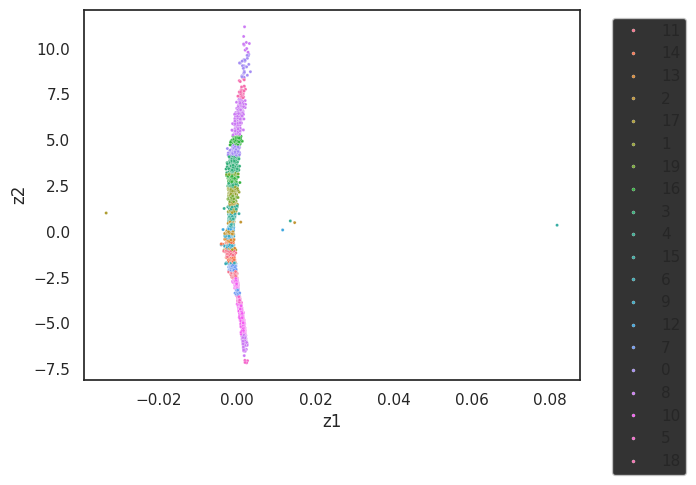

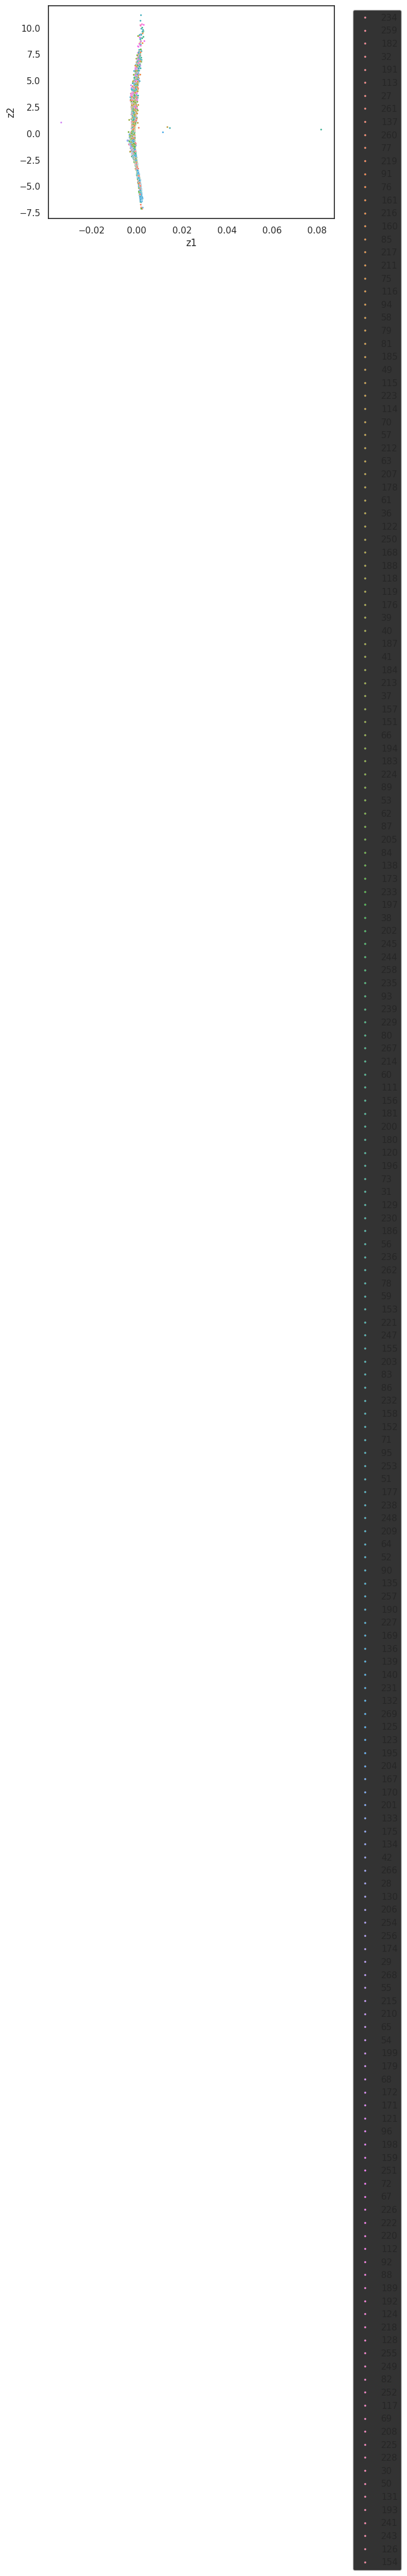

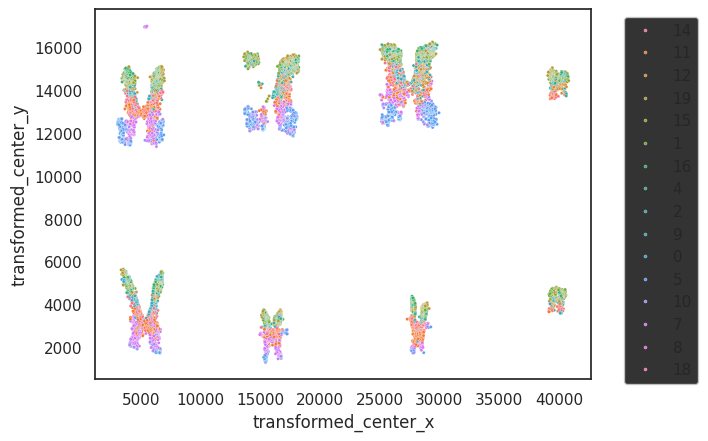

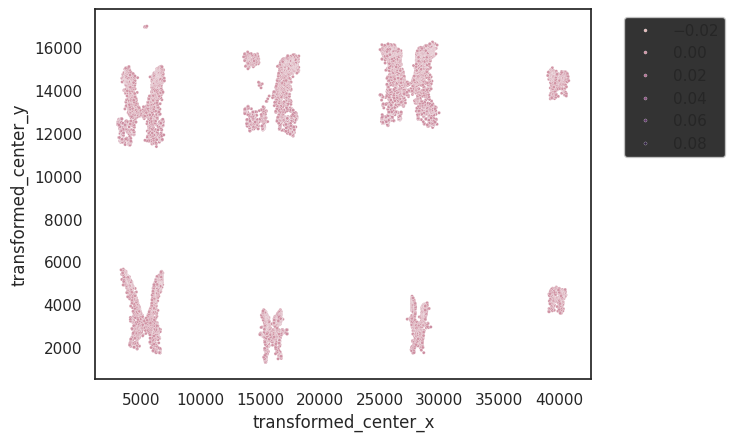

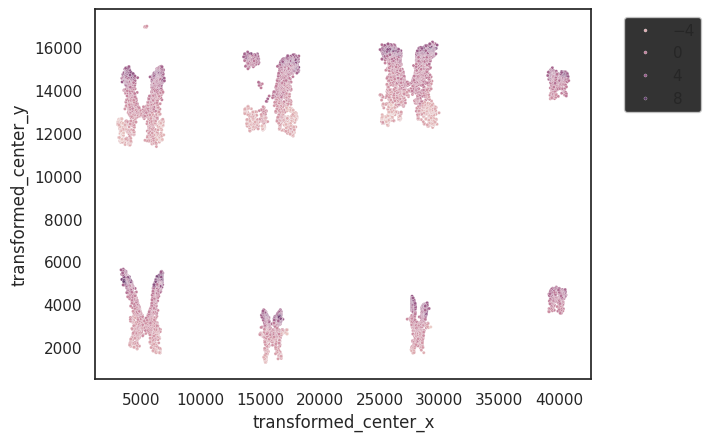

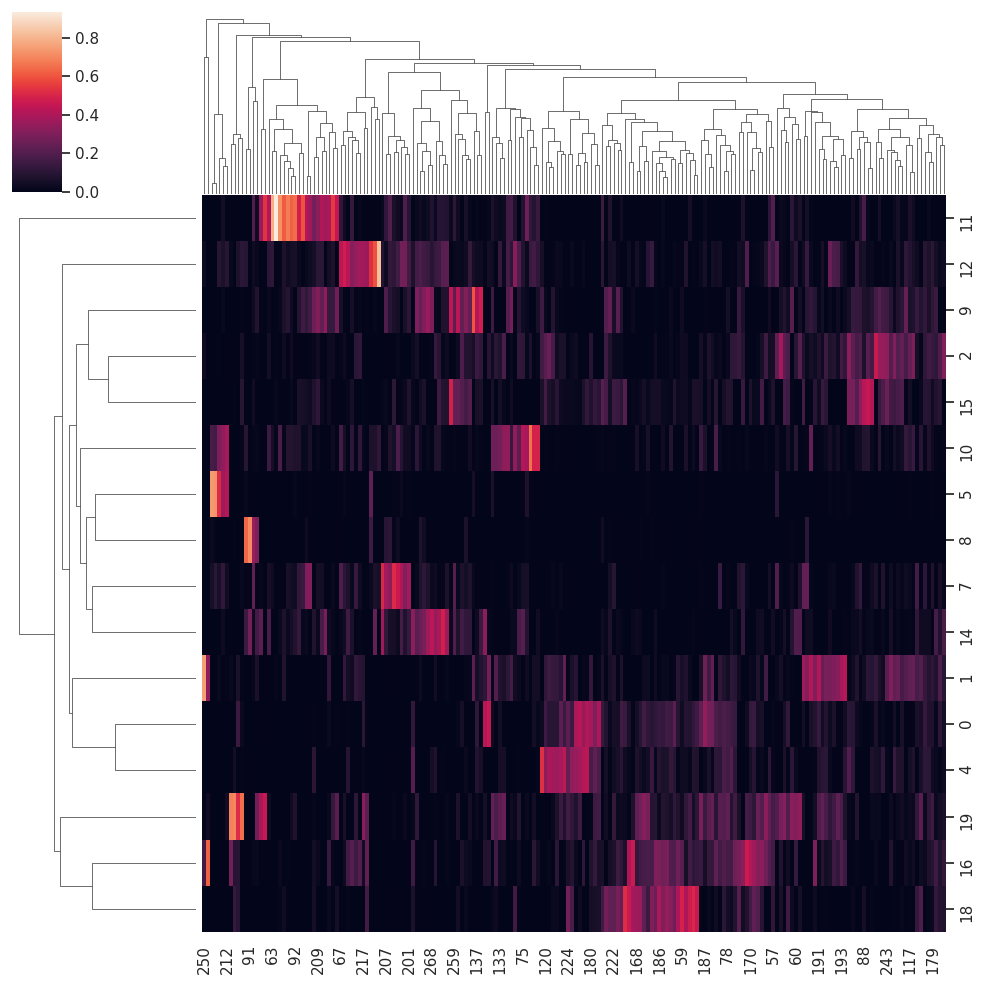

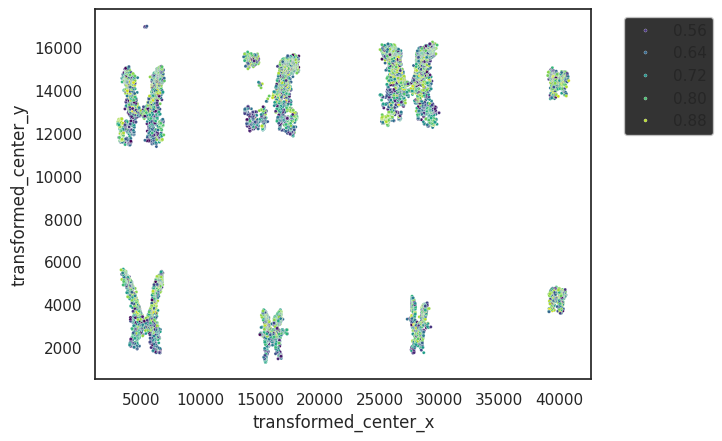

/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/lamination_station/src/lamination_station/plotting.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Axes: xlabel='x_graph', ylabel='y_graph'>,
 <Axes: xlabel='x_graph', ylabel='y_graph'>)

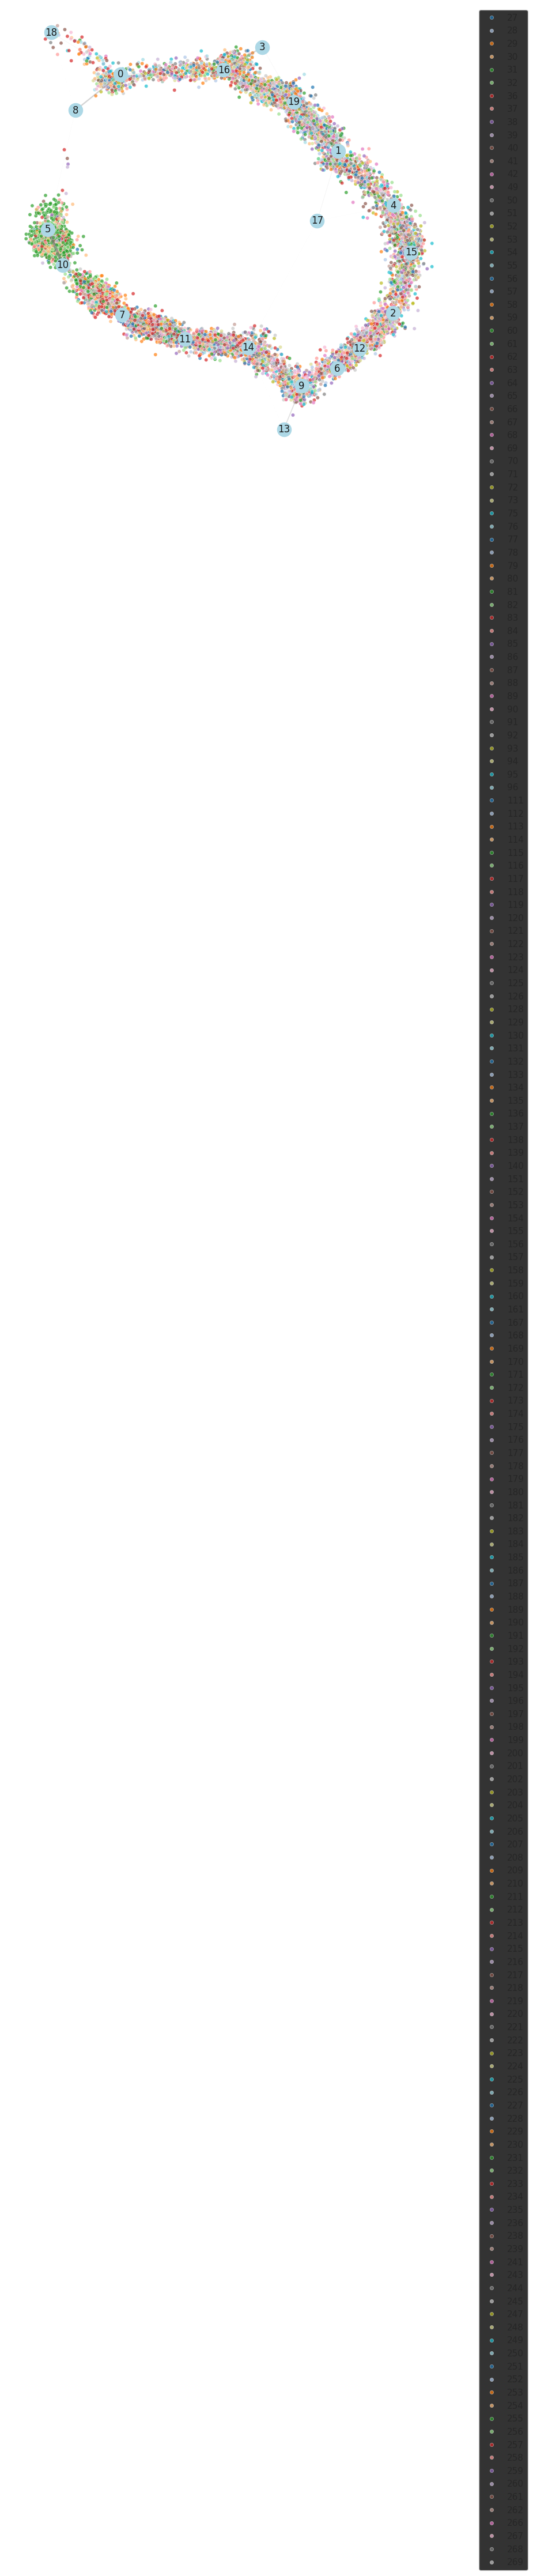

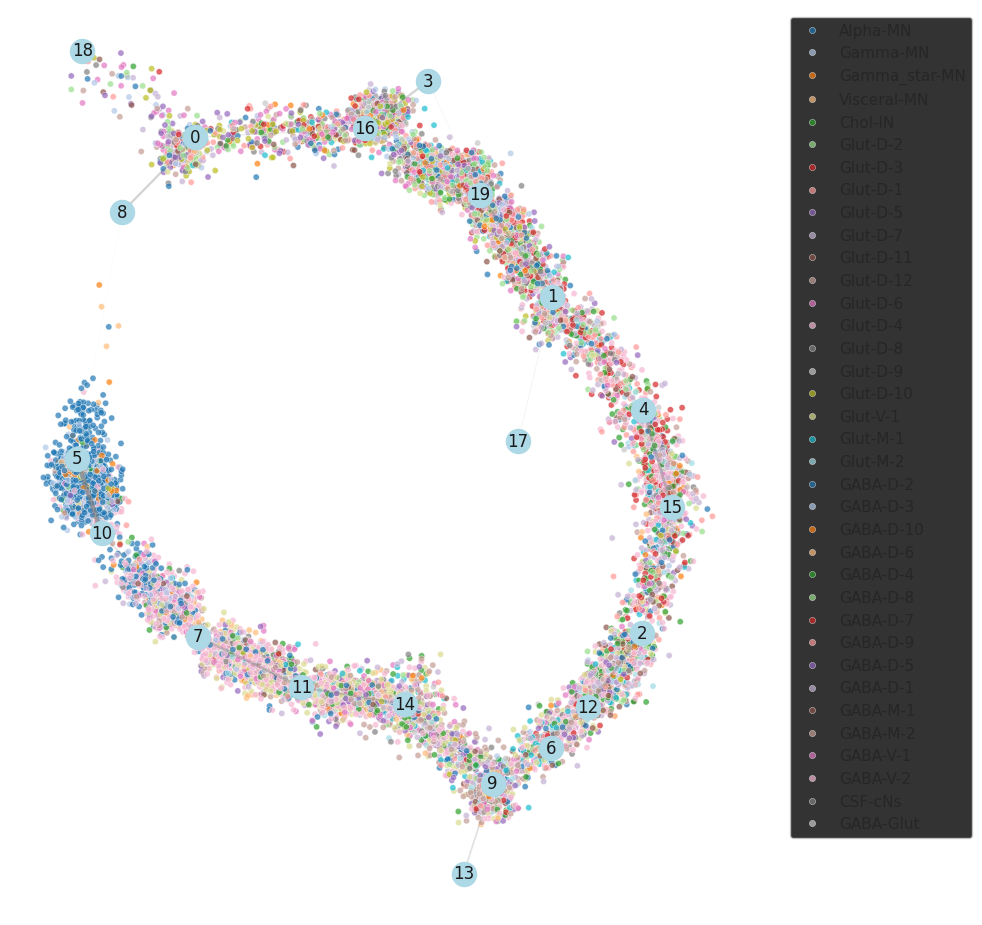

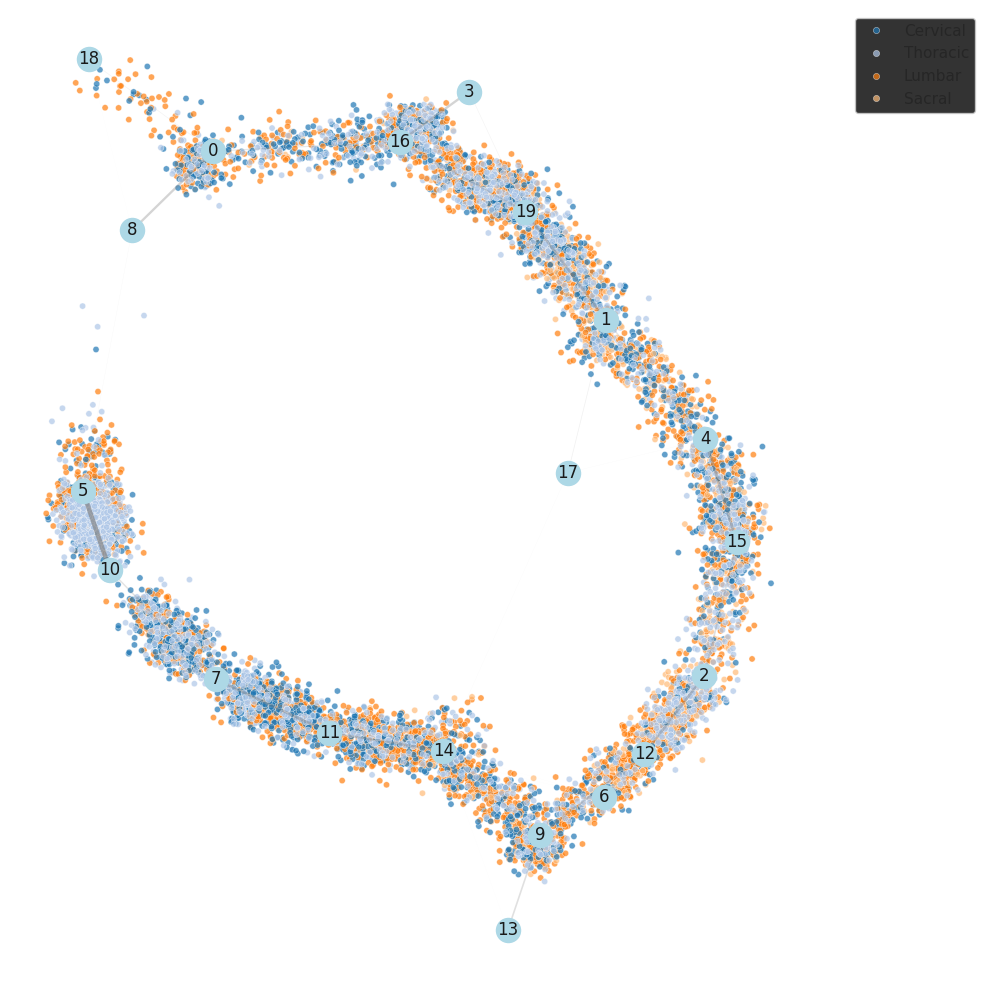

In [62]:
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out['structure_pred1'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out['structure_pred2'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out['z1'], y=out['z2'], hue=out[taxon_level].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['structure_pred1'].astype(str), s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['z1'], s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()
seaborn.scatterplot(x=out[x_col], y=out[y_col], hue=out['z2'], s=5)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.show()


try:
    comp_df = pd.DataFrame(struct_comp,columns=df_grads[taxon_level].cat.categories.sort_values()).loc[out['structure_pred1'].cat.categories.astype(int)]
    seaborn.clustermap(comp_df/comp_df.sum(0))
    plt.show()
except:
    print('flat comp_df')

seaborn.scatterplot(
    x=out[x_col],
    y=out[y_col],
    hue=out["phi"],
    s=5.,
    palette="viridis"
)
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
# cb = plt.colorbar()
# cb.set_label("phi = p1/(p1+p2)")
plt.show()

# build & draw co-occurrence graph
# build sets of samples where each struct appears in top2
top2_arr = np.stack([out['structure_pred1'].astype(int),out['structure_pred2'].astype(int)],axis=-1)
N, S = top2_arr.shape[0], struct_logits.shape[1]
sets = {s: set(np.where((top2_arr == s).any(axis=1))[0]) for s in range(S)}

G = nx.Graph()
G.add_nodes_from(range(S))
for u in range(S):
    for v in range(u+1, S):
        A, B = sets[u], sets[v]
        if not A or not B:
            continue
        # overlap coefficient
        w = len(A & B) / len(A | B)#min(len(A), len(B)) # len(A | B)
        if w > 0:
            G.add_edge(u, v, weight=w)

lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col=taxon_level,
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)
lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='Group',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)

lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='segment',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)



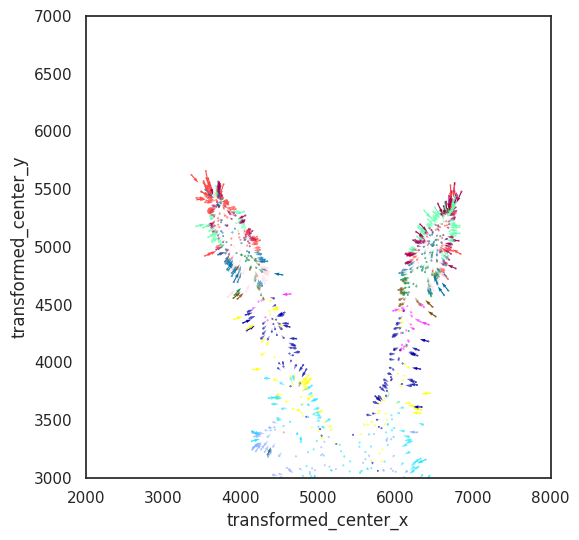

In [63]:
# Just plotting arrows
xlim = (2000,8000) # You'll need to pick your own coords
ylim = (3000,7000)
lamination_station.pl.plot_gradient_arrows(out,gradients,'structure_pred1',x_col,y_col,xlim,ylim,scale=0.004)

# Assigning depth on graph

In [64]:
import numpy as np
import networkx as nx
import pandas as pd

def _node_diffusion_shortest_path(G, source, weight='weight'):
    # 1) get weighted shortest‐path lengths
    dists = nx.single_source_dijkstra_path_length(G, source, weight=weight)
    if not dists:
        # only source exists
        return {n: (1.0 if n == source else 0.0) for n in G.nodes()}
    max_d = max(dists.values())
    # 2) invert+normalize to [0,1]
    return {
        n: (1.0 - dists.get(n, np.inf) / max_d) if np.isfinite(dists.get(n, np.inf)) else 0.0
        for n in G.nodes()
    }

def _node_diffusion_pagerank(G, source, alpha=0.85, weight='weight'):
    # 1) set up personalization vector
    pers = {n: 1.0 if n == source else 0.0 for n in G.nodes()}
    # 2) run PPR
    pr = nx.pagerank(G, alpha=alpha, personalization=pers, weight=weight, max_iter=10000,tol=1.0e-5)
    vals = np.fromiter(pr.values(), float)
    lo, hi = vals.min(), vals.max()
    # 3) normalize into [0,1]
    if hi > lo:
        return {n: ((v - lo) / (hi - lo))**0.5 for n, v in pr.items()} #Added 0.5 since decay seems square/exp
    else:
        return {n: 0.0 for n in pr}

def compute_cell_diffusion(
    out: pd.DataFrame,
    G: nx.Graph,
    source_node: int,
    method: str = 'pagerank',
    **diff_kwargs
) -> pd.DataFrame:
    """
    Returns a copy of `out` with a new column `diffusion` in [0,1].

    Parameters
    ----------
    out : DataFrame
        Must have 'structure_pred1', 'structure_pred2', 'phi' columns.
    G : Graph
        Full structure‐graph with numeric node IDs.
    source_node : int
        Node in G from which to diffuse.
    method : {'shortest_path','pagerank'}
        Which node‐diffusion to use.
    diff_kwargs :
        Passed to the underlying diffusion function:
          - for shortest_path: weight='weight'
          - for pagerank: alpha=0.85, weight='weight'
    """
    # 1) compute diffusion on graph nodes
    if method == 'shortest_path':
        node_scores = _node_diffusion_shortest_path(G, source_node, **diff_kwargs)
    elif method == 'pagerank':
        node_scores = _node_diffusion_pagerank(G, source_node, **diff_kwargs)
    else:
        raise ValueError(f"Unknown method {method!r}")

    # 2) map scores to each end of the predicted‐edge
    print(node_scores)
    d1 = out['structure_pred1'].astype(int).replace(node_scores).fillna(0.0)
    d2 = out['structure_pred2'].astype(int).replace(node_scores).fillna(0.0)

    # 3) interpolate along phi
    df = out.copy()
    df['diffusion'] = df['phi'] * d1 + (1 - df['phi']) * d2
    return df

# ── Example ──
# Assuming your `out` already exists and G was built as before:
out = compute_cell_diffusion(
    out, G,
    source_node=5,         # whichever structure‐node you want as source
    method='pagerank',     # or 'pagerank'
    alpha=0.99
)


{0: np.float64(0.6257578558727891), 1: np.float64(0.5982781061995629), 2: np.float64(0.6300345862211029), 3: np.float64(0.450028173504125), 4: np.float64(0.583927914590995), 5: np.float64(0.9299425205143939), 6: np.float64(0.13568118114875555), 7: np.float64(0.7311160342649619), 8: np.float64(0.5137467348956998), 9: np.float64(0.6593397658438604), 10: np.float64(1.0), 11: np.float64(0.7787959926040569), 12: np.float64(0.5993390489375499), 13: np.float64(0.33015656023974393), 14: np.float64(0.6433198678955846), 15: np.float64(0.5884924300614035), 16: np.float64(0.672495492240158), 17: np.float64(0.20180437399737863), 18: np.float64(0.0), 19: np.float64(0.6250059114556058)}


In [50]:
# G.remove_edge(2,6) #one way to cheat to try to get a useful 
# G.remove_edge(8,5)
# G.remove_edge(17,14)

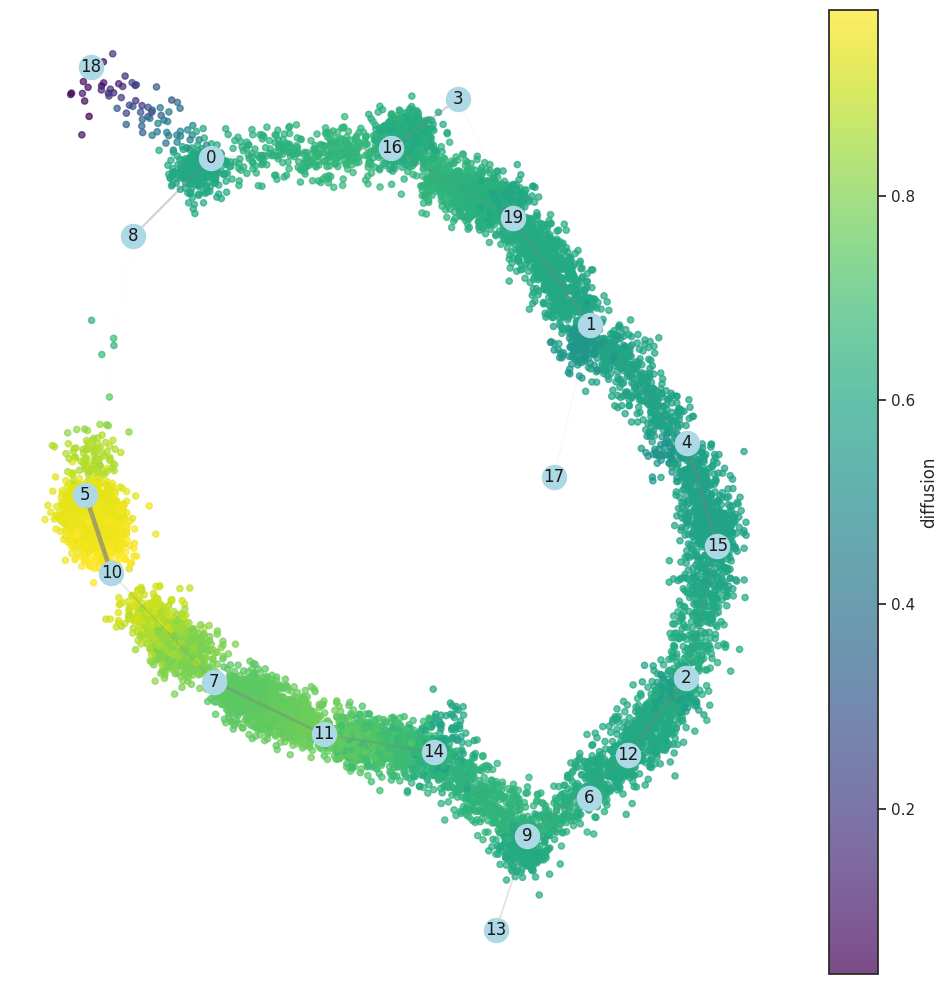

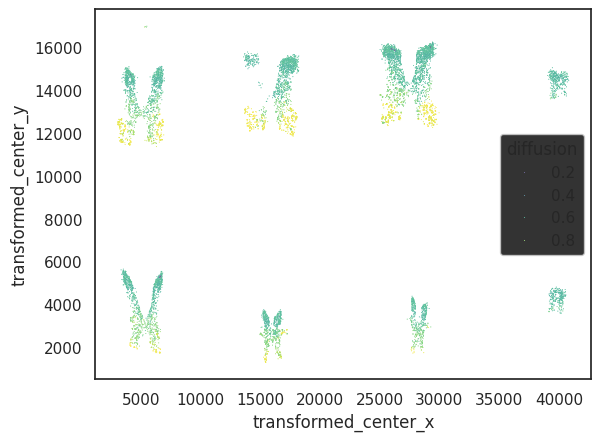

In [65]:
lamination_station.pl.plot_cells_on_structure_graph(
    out=out,
    G=G,
    jitter=0.03,      # e.g. 0.01–0.1
    cell_size=20,
    cell_alpha=0.7,
    color_col='diffusion',
    figsize=(10,10),
    spring_k=0.1,     # tune for spacing
    seed=42
)
plt.show()

seaborn.scatterplot(
    x=out[x_col],
    y=out[y_col],
    hue=out["diffusion"],
    s=0.5,
    palette="viridis"
)
plt.show()

In [66]:
q99 = np.quantile(out['diffusion'],0.99)
q01 = np.quantile(out['diffusion'],0.01)
out['diffusion_normalized'] = np.clip(out['diffusion'],q01,q99)
out['diffusion_normalized'] = (out['diffusion_normalized'] -out['diffusion_normalized'].min()) / (out['diffusion_normalized'].max()-out['diffusion_normalized'].min())

<Axes: xlabel='diffusion', ylabel='Count'>

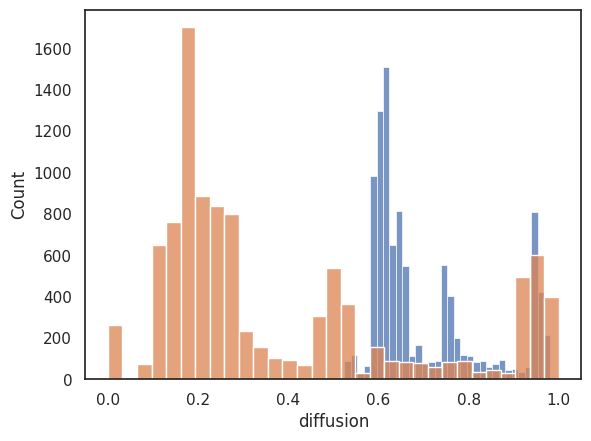

In [67]:
seaborn.histplot(out['diffusion'])
seaborn.histplot(out['diffusion_normalized'])

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/lamination_station/lib/python3.13/site-packages/seaborn/axis

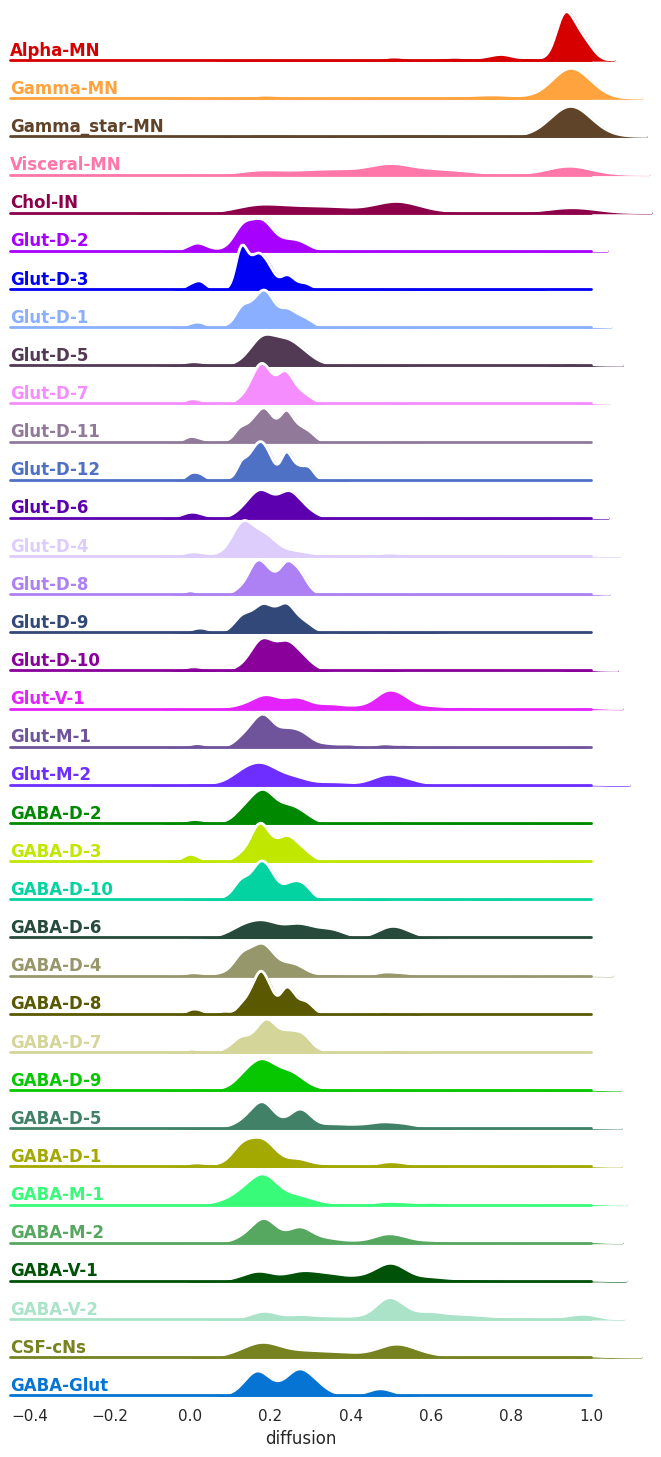

In [68]:
# Example ridgeplot code, you'll need to modify significantly and make your own color dict
color_dict = dict(zip(merged_adata.obs['Group'].cat.categories,merged_adata.uns['Group_colors']))
seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
groups = out['Group'].unique()
pal = seaborn.cubehelix_palette(len(groups), rot=-.25, light=.7)
unique_groups = out['Group'].cat.categories.tolist()
# if you want the rows in the same order as your dict:
row_order = [g for g in color_dict.keys() if g in unique_groups]

# build a palette mapping just those groups
palette = { g: color_dict[g] for g in row_order }



g = seaborn.FacetGrid(
    out,
    row="Group",
    hue="Group",
    aspect=15,
    height=0.5,
    palette=palette
)

g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5
)
g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=0.5
)
g.refline(
    y=0,
    linewidth=2,
    linestyle="-",
    color=None,
    clip_on=False
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes
    )

g.map(label, "diffusion")

# overlap the plots
g.figure.subplots_adjust(hspace=-0.25)

# clean up
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.xlim((-.45,1.))
plt.show()


In [ ]:
out['consensus_cluster_group'] = out['Group'].astype(str) +'__'+ out['consensus_cluster'].astype(str)
out['consensus_cluster_group'] = out['consensus_cluster_group'].astype('category')
vcs = out['consensus_cluster_group'].value_counts()
sub_out = out.loc[out['consensus_cluster_group'].isin(vcs.index[vcs>20])]

cat = 'consensus_cluster_group'

color_dict = dict(zip(merged_adata.obs['Group'].cat.categories,merged_adata.uns['Group_colors']))
unique_cats = sub_out['consensus_cluster_group'].cat.categories.tolist()
unique_groups = sub_out['consensus_cluster_group'].cat.categories.str.split('__').str[0].tolist()
# if you want the rows in the same order as your dict:
row_order = unique_cats
row_order_groups = pd.Series(row_order).str.split('__').str[0].tolist()

# build a palette mapping just those groups
palette = { k: color_dict[g] for k,g in zip(row_order,row_order_groups)}

seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = seaborn.FacetGrid(
    sub_out,
    row=cat,
    hue=cat,
    aspect=15,
    height=0.5,
    palette=palette
)

g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    bw_adjust=0.5,
    clip_on=False,
    fill=True,
    alpha=1,
    linewidth=1.5
)
g.map(
    seaborn.kdeplot,
    "diffusion_normalized",
    clip_on=False,
    color="w",
    lw=2,
    bw_adjust=0.5
)
g.refline(
    y=0,
    linewidth=2,
    linestyle="-",
    color=None,
    clip_on=False
)

def label(x, color, label):
    ax = plt.gca()
    ax.text(
        0,
        0.2,
        label,
        fontweight="bold",
        color=color,
        ha="left",
        va="center",
        transform=ax.transAxes
    )

g.map(label, "diffusion")

# overlap the plots
g.figure.subplots_adjust(hspace=-0.25)

# clean up
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

plt.show()


In [ ]:
import pyro
pyro.param('theta_a')

In [ ]:
pyro.param('theta_b')